## Oct. Coding Club: Is local connectivity specific or random?
If we presume that local connections are random, and simply occur due to two neurons being in close proximity, then it follows that the more arbours there are of one neuron within radius r of a target neuron, then the more likely this neuron makes connections with the target neuron. If there is non-random connectivity, however, there is unlikely to be a correlation between arbour counts within r and number of connections between the two neurons. The goal for this coding club is to test these two hypotheses.


In [2]:
import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm import tqdm 
import scipy

from fafbseg import flywire

## 1. Make a function that takes an x,y,z location (p) in FlyWire and a radius length r (in either voxels or nms), and n (number of points sampled per side).
This function should return a list of voxel locations evenly distributed within a sphere around point p with radius r. Feel free to mess around with how dense the distribution of voxel locations is.

### One possible way to do this:
- Create a cube with size 2r that is centered at p.
- For the cube with side length l, get n points per side (with l/n distance between each point) (n can/will vary significantly depending on how large r is). This will get you 3 lists (x_list, y_list, z_list) of equal size.
- To evenly sample across the cube then, get all possible combinations of points made of one element from each list (x_list[i], y_list[j], z_list[k]). This will give you a list of locations (p_list).
- Remove all locations in p_list where the euclidean distance to p > r.
There are other ways to do this though.

In [3]:
### euclid_helper((3,1)array:loc, (3,1)array:p)
### just a quick euclidean distance function so I can map nicely
### returns distance from p to loc
def euclid_helper(loc, p):
    [x,y,z] = p
    return math.sqrt((loc[0]-x)**2+(loc[1]-y)**2+(10*(loc[2]-z))**2)

In [4]:
### in_sphere((3,1)array:loc, list of (3,)arrays: locs, int: r)
### looks at all the x,y,z points in locs and determines which 
### are inside of the sphere around loc w/ radius r
### returns list of Binary which functions as a mask on locs

def in_sphere(loc, locs, r):
    print("Sphere check starting!")
    [x,y,z] = loc
    in_sphere = []
#    for loc in tqdm(locs):
#        curr_dist = math.sqrt((loc[0]-x)**2+(loc[1]-y)**2+(10*(loc[2]-z))**2)
#        in_sphere.append(curr_dist<r)
    curr_dist = np.asarray(list(map(euclid_helper, locs, [loc]*len(locs))))
    in_sphere = curr_dist<r
    print("Sphere check done!")
    return in_sphere

In [5]:
### sampler((3,1)array:loc, int r, int n)
### evenly samples inside a sphere around loc w/ radius r
### and n/2 points sampled along each radius (in an ideal world)
### returns list of (3,1)arrays that are the sampling points in the sphere

def sampler(loc, r, n):
    [x,y,z] = loc
    cube_locs = []
    cube_dists = []
    # first we make a cube that is centered at loc
    # and has side length 2r and has sample locations
    # at each 2r/n point
    for xi in tqdm(np.linspace(x-r, x+r, n)):
        for yi in np.linspace(y-r, y+r, n):
            for zi in np.linspace(z-(r/10), z+(r/10), n):
                #print(zi)
                cube_locs.append([xi, yi, zi])
    cube_locs = np.asarray(cube_locs)
    print('Sampling Done!')
    return cube_locs[in_sphere([x,y,z], cube_locs, r)]

In [6]:
sample_locs = sampler([112367, 56132, 3613], 5000, 25)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1479.83it/s]

Sampling Done!
Sphere check starting!
Sphere check done!


In [7]:
flywire.encode_url(720575940621039145, coords=[112367, 56132, 3613], annotations = sample_locs)

'https://ngl.flywire.ai/?json_url=https://globalv1.flywire-daf.com/nglstate/6409700690100224'

## 2. Choose a neuron, and set p as a point in the axon of the neuron. Run the function you described above with different r values until you get a somewhat normal looking distribution of counts of root Ids.
Fetch the root IDs at each of the locations within the sphere. This should be a general quantification of amount of arbour near the target location. You will want to make sure you know how many times each root ID appears within the set of points you constructed earlier.
Optional: feel free to restrict this to juse proofread neurons, or if that is messy then just neurons that are above a certain size. Try a few things until you get a good understanding.


In [8]:
### id_counter((3,) list of arrays:locs)
### literally just returns np.unique(x, return_counts=True) where x is the 
### body ids assocated with some locations you pass
def id_counter(locs):
    ids = []
    if len(locs)>100000:
        i = 0
        run=1
        print("More than 1000000 locs given, will need "+str(len(locs)/1000000)+" id grabs w/ size 1000000 each")
        while len(locs)-i>1000000:
            print("Run "+str(run))
            ids = ids + list(flywire.locs_to_segments(locs[i:i+1000000]))
            i+=1000000
            run+=1
        ids = np.asarray(ids+list(flywire.locs_to_segments(locs[i:])))
    else:
        ids = flywire.locs_to_segments(locs)
    return np.unique(ids, return_counts=True)

In [9]:
counts = id_counter(sampler([112367, 56132, 3613], 5000, 150))

100%|██████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 61.43it/s]


Sampling Done!
Sphere check starting!
Sphere check done!
More than 1000000 locs given, will need 1.731608 id grabs w/ size 1000000 each
Run 1


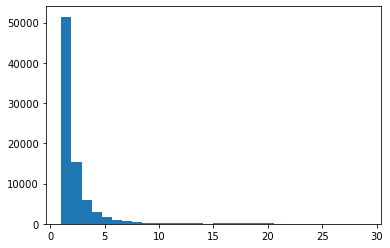

In [10]:
plt.hist(counts[1][counts[1]<30],bins=30)
plt.show()

## 3. Fetch the synapses from the target neuron (the neuron that is located at p). Of the synapses that are within the sphere around p, fetch the root IDs of the downstream (or upstream if you’re looking at a dendrite area) neurons.
Plot arbour amounts vs. synapse number. Plot the line of best fit and the R-squared value for this correlation (if it’s non-linear see if you can fit a function to it).
Does the correlation or the R-squared vary as you vary radius r? Test a few locations in FlyWire to see if different neuropils have different values.

In [11]:
### synapse_fetcher((3,1)array: loc, int: r)
### simply grabs all the synapses of the neuron at loc in a sphere
### returns the np.unique(x, return_counts=True) where x is the ids 
### of synapses that are inside of a sphere centered at loc w/ radius r
def synapse_fetcher(loc, r):
    loc_id = flywire.locs_to_segments([loc])
    syns = flywire.synapses.fetch_synapses(loc_id)
    locs = np.asarray([np.asarray(syns.pre_x)/4, np.asarray(syns.pre_y)/4, np.asarray(syns.pre_z)/40]).T
    mask = in_sphere(loc, locs, r)
    return np.unique(list(syns[mask].pre)+list(syns[mask].post), return_counts=True)

In [12]:
#synapses = synapse_fetcher([112367, 56132, 3613], 5000)

In [13]:
# syn_table = pd.DataFrame(index=synapses[0], columns=['syn_count'])
# syn_table.syn_count = synapses[1]
# sample_table = pd.DataFrame(index=counts[0], columns=['sample_count'])
# sample_table.sample_count = counts[1]

# out_table = syn_table.merge(sample_table, left_index=True, right_index=True)
# out_table.fillna(0, inplace=True)
# out_table.sort_values(by='sample_count', inplace=True)
# plot_table = out_table.drop(flywire.locs_to_segments([[112367, 56132, 3613]]))

In [14]:
# plotter = plot_table.plot(kind='scatter', x='sample_count', y='syn_count', xlabel='Occurences in Sphere', ylabel='# of Synapses with Target')
# #plotter.set_xscale('log')
# plotter.set_title('Occurences of ID in Sampled Sphere vs. Synapses Made with Target')
# slope, intercept, r_value, p_value, _ = scipy.stats.linregress(plot_table.sample_count, plot_table.syn_count)
# plt.plot(plot_table.sample_count, a*plot_table.sample_count+b)
# plt.text(1, 17, 'y = ' + '{:.6f}'.format(intercept) + ' + {:.6f}'.format(slope) + 'x', size=14)
# plt.text(1, 15, 'r2 = '+ '{:.6f}'.format(r_value), size=14)
# plt.text(1, 13, 'p = '+ '{:.6f}'.format(p_value), size=14)
# plt.show()

In [17]:
def runner(loc, r, n, ret_table=False):
    sampled_locs = sampler(loc, r, n)
    counts = id_counter(sampled_locs)
    syns = synapse_fetcher(loc, r)
    
    syn_table = pd.DataFrame(index=syns[0], columns=['syn_count'])
    syn_table.syn_count = syns[1]
    
    sample_table = pd.DataFrame(index=counts[0], columns=['sample_count'])
    sample_table.sample_count = counts[1]

    out_table = syn_table.merge(sample_table, left_index=True, right_index=True)
    out_table.fillna(0, inplace=True)
    
    plot_table = out_table.drop(flywire.locs_to_segments([loc]))
    if ret_table:
        return plot_table
    
    plotter = plot_table.plot(kind='scatter', x='sample_count', y='syn_count', xlabel='Occurences in Sphere', ylabel='# of Synapses with Target')
    #plotter.set_xscale('log')
    plotter.set_title('Occurences of ID in Sampled Sphere vs. Synapses Made with Target')
    slope, intercept, r_value, p_value, _ = scipy.stats.linregress(plot_table.sample_count, plot_table.syn_count)
    plt.plot(plot_table.sample_count, slope*plot_table.sample_count+intercept)
    plt.text(1, 17, 'y = ' + '{:.6f}'.format(intercept) + ' + {:.6f}'.format(slope) + 'x', size=14)
    plt.text(1, 15, 'r2 = '+ '{:.6f}'.format(r_value), size=14)
    plt.text(1, 13, 'p = '+ '{:.6f}'.format(p_value), size=14)
    plt.show()

In [ ]:
runner([112367, 56132, 3613],5000,500)#.show()

100%|██████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:06<00:00,  7.54it/s]


Sampling Done!
Sphere check starting!
Sphere check done!
More than 1000000 locs given, will need 65.052408 id grabs w/ size 1000000 each
Run 1


Run 2


Run 3


Run 4


Run 5


Run 6


Run 7


Run 8


Run 9


Run 10


Run 11


Run 12


Run 13


Run 14


Run 15


Run 16


Run 17


Run 18


Run 19


Run 20


Run 21


Run 22


Run 23


Run 24


Run 25


Run 26


Run 27


Run 28


Run 29


Run 30


Run 31


Run 32


Run 33


Run 34


Run 35


Run 36


Run 37


Run 38


Run 39


Run 40


Run 41


Run 42


Run 43


Run 44


Run 45


Run 46


Run 47


Run 48


Run 49


Run 50


Run 51


Run 52


Run 53


Run 54


Run 55


Run 56


Run 57


Run 58


Run 59


Run 60


Run 61


Run 62


Run 63


Run 64


Run 65


Fetching roots:  89%|████████████████████████████████████████████████████████▉       | 890000/1000000 [01:30<00:10, 10769.79it/s]

## Bonus challenge: Instead of focusing on a specific neuron, fetch all synapses within the sphere and ask if higher arbour counts are correlated with more synapses.